Визуальный анализ данных и построение признаков
На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, связанных со временем посещения сайта, потом Вы сможете сами придумать и описать различные признаки. Задание имеет вид Peer-Review, так что творчество здесь активно приветствуется. Если задействуете IPython-виджеты, библиотеку Plotly, анимации и прочий интерактив, всем от этого будет только лучше.

План задания:

1. Построение признаков
2. Визуальный анализ данных
3. Проверка построенных признаков
4. Дальнейшее построение признаков

## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import scipy.sparse as sps
from scipy.sparse import csr_matrix
from tqdm.auto import tqdm
from time import time

In [3]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'capstone_user_identification'

Создайте на основе функций prepare_train_set и prepare_sparse_train_set_window новую – prepare_train_set_with_fe, (от "feature engineering"), создайте следующие признаки:

* session_timespan – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
* #unique_sites – число уникальных сайтов в сессии
* start_hour – час начала сессии (то есть час в записи минимального timestamp среди десяти)
* day_of_week – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция prepare_train_set), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: site1, ... site10, session_timespan, #unique_sites, start_hour, day_of_week и user_id (это видно и чуть ниже по тому, как функция вызывается).

In [4]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    #получить все файлы
    stock_files = sorted(glob(path_to_csv_files))
    
    #получить файл со словарем
    df_site_dict = pd.read_pickle(site_freq_path)
    
    #полуить первым шагом матрицу в соответствие с условиями
    data = []
    user = 1
    for filename in stock_files:
        tmp_df = pd.read_csv(filename)
        tmp_df['timestamp'] = pd.to_datetime(tmp_df['timestamp'])
        start_hour_site = list(tmp_df['timestamp'].dt.hour)
        day_of_week_site = list(tmp_df['timestamp'].dt.weekday)
        list_site = []
        list_time = list((tmp_df.iloc[:, 0].shift(-1)-tmp_df.iloc[:, 0])/np.timedelta64(1,'s'))
        list_time = list_time[0:len(list_time)-1]
        list_time = [round(x) for x in list_time]
        for site in tmp_df.site:
            list_site.append(df_site_dict.get(site))
        count = 0
        for start in range(0, (len(list_site) + window_size), window_size):
            ind_1 = start
            ind_2 = start + session_length
            sess_uniq = []
            if ind_2 <= (len(list_site)-1):
                sess = list_site[ind_1 : ind_2]
                sess_time = list_time[ind_1 : ind_2-1]
                sess_uniq = list(filter(lambda num: num != 0, sess))
                data.append(sess + sess_time + [sum(sess_time)] + [len(set(sess_uniq))] + [start_hour_site[start]] + 
                            [day_of_week_site[start]] + [user])
            else:
                if(len(list_site[ind_1:])==0):
                    break
                sess = list_site[ind_1:] + [0 for _ in range(session_length - len(list_site[ind_1:]))]
                sess_uniq = list(filter(lambda num: num != 0, sess))
                sess_time = list_time[ind_1:] + [0 for _ in range(session_length - len(list_time[ind_1:])-1)]
                data.append(sess + sess_time + [sum(sess_time)] + [len(set(sess_uniq))] + [start_hour_site[start]] + 
                            [day_of_week_site[start]] + [user])
        user = user + 1
        
    tmp_arr = np.array(data)
    
    #вторым шагом получим разряженную матрицу
    row = 0
    rows = []
    cols = []
    data = []

    for arr in tmp_arr:
        for key, value in enumerate(arr):
            if value != 0:
                rows.append(row)
                cols.append(key)
                data.append(value)
        row = row + 1
        
    #третьим шагом получим требуемый датафрейм
    B = sps.coo_matrix((data, (rows, cols))).tocsr()
    
    return(pd.DataFrame(B.toarray(), columns=feature_names))

In [5]:
t_start = time()

feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users/*.csv'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

print("Time elapsed", time() - t_start)

Time elapsed 0.07461786270141602


In [6]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3,2,2,7,2,1,8,5,9,10,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,3,2,6,6,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,4,1,2,1,2,1,1,5,11,4,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


#### Примените функцию prepare_train_set_with_fe к данным по 10 пользователям, укажите session_length=10.

In [7]:
t_start = time()

feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users/*.csv'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

print("Time elapsed", time() - t_start)

Time elapsed 1.8972265720367432


In [8]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,192,574,133,3,133,133,3,133,203,133,10,0,0,1,20,1,0,1,0,33,5,8,4,1
1,415,193,674,254,133,31,393,3305,217,55,1,0,163,105,0,1,3,3,8,284,10,8,4,1
2,55,3,55,55,5,293,415,333,897,55,0,14,1,242,0,0,1,0,0,258,7,8,4,1
3,473,3306,473,55,55,55,55,937,199,123,2,1,0,1,25,1,0,0,0,30,6,8,4,1
4,342,55,5,3307,258,211,3308,2086,675,2086,1,0,1,1,1,0,1,1,0,6,9,8,4,1


#### Примените функцию prepare_train_set_with_fe к данным по 150 пользователям, укажите session_length=10.

In [9]:
t_start = time()

feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users/*.csv'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

print("Time elapsed", time() - t_start)

Time elapsed 18.358577966690063


In [10]:
train_data_150users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,1,4,2,1,4,1,2,1290,321,1,1,1,4,0,1,0,49,0,57,5,8,4,1
1,2,23,1505,1290,321,321,113,73,49,49,0,0,26,1,10,73,0,1504,4,1618,8,8,4,1
2,321,205,1,1,1,1,73,321,2,1,1,10,1,5,16,56,1917,0,4,2010,5,8,4,1
3,1,1,6998,6998,5491,6998,6998,1,35,1,1,0,1,0,118,420,1460,6,0,2006,4,9,4,1
4,1,1,76,1,58,50,58,50,83,76,4,3,0,1,0,1,0,1,0,10,5,9,4,1


#### Сохраните в pickle-файлы признаки session_timespan, #unique_sites, start_hour и day_of_week для 10 и 150 пользователей.

In [11]:
new_feature_names = ['time_diff' + str(j) for j in range(1,10)] + \
                    ['session_timespan', '#unique_sites', 'start_hour','day_of_week']

In [12]:
new_features_10users = train_data_10users[new_feature_names]
new_features_150users = train_data_150users[new_feature_names]

In [13]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<span style="color:red">Вопрос 1.</span> Выведите медианную продолжительность сессии (session_timespan) для сессий 10 пользователей.**

In [14]:
import statistics

In [15]:
median = statistics.median(train_data_10users.session_timespan.values)
print('Медианная продолжительность сессии для сессий 10 пользователей составляет ', median)


Медианная продолжительность сессии для сессий 10 пользователей составляет  37


**<span style="color:red">Вопрос 2.</span> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [16]:
median = statistics.median(train_data_10users.day_of_week.values)
print('Медианная день недели для сессий 10 пользователей составляет ', median)

Медианная день недели для сессий 10 пользователей составляет  2


**<span style="color:red">Вопрос 3.</span> Выведите медианный час начала сессии для сессий 150 пользователей.**

In [17]:
median = statistics.median(train_data_150users.start_hour.values)
print('Медианный час для начала сессии для 150 пользователей составляет ', median)

Медианный час для начала сессии для 150 пользователей составляет  13


**<span style="color:red">Вопрос 4.</span> Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [18]:
median = statistics.median(train_data_150users['#unique_sites'].values)
print('Медианное значение числа уникальных сайтов для 150 пользователей составляет ', median)

Медианное значение числа уникальных сайтов для 150 пользователей составляет  7


## Часть 2. Визуальный анализ данных

In [19]:
'''id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)'''

"id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',\n               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}\ntrain_data_10users['target'] = train_data_10users['target'].map(id_name_dict)"

In [20]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (session_timespan). Ограничьте по x значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета darkviolet, подпишите оси по-русски.**

In [21]:
x = train_data_10users[train_data_10users.session_timespan < 200].session_timespan

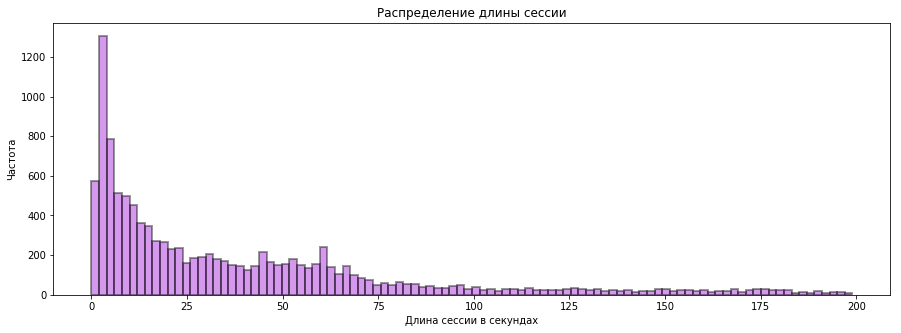

In [22]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.distplot(x, bins=100, kde=False, color='darkviolet', hist_kws=dict(edgecolor="k", linewidth=2))
plt.title("Распределение длины сессии")
plt.xlabel("Длина сессии в секундах")
plt.ylabel("Частота")
plt.show()

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (#unique_sites). Сделайте гистограмму цвета aqua, подпишите оси по-русски.**

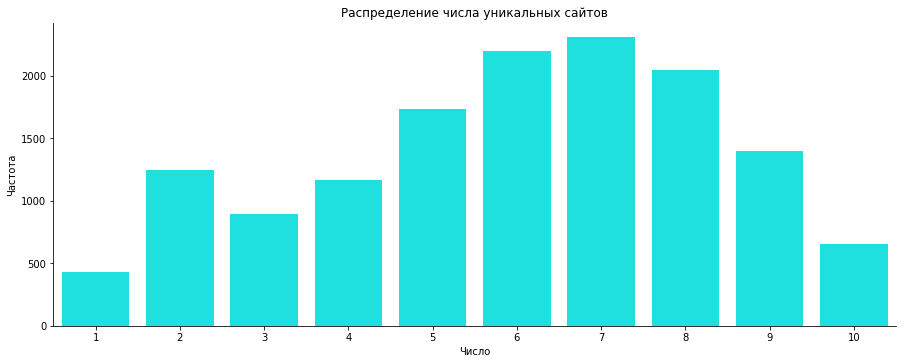

In [23]:
ax =sns.catplot(x="#unique_sites", kind="count", color='aqua', data=train_data_10users, height=5, aspect=2.5)
plt.title("Распределение числа уникальных сайтов", fontsize=12)
plt.xlabel("Число", fontsize=10)
plt.ylabel("Частота", fontsize=10)
plt.show()

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (#unique_sites) для каждого из 10 пользователей по отдельности. Используйте subplots, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (color_dic). Подпишите оси по-русски в каждой из 10 гистограмм.**

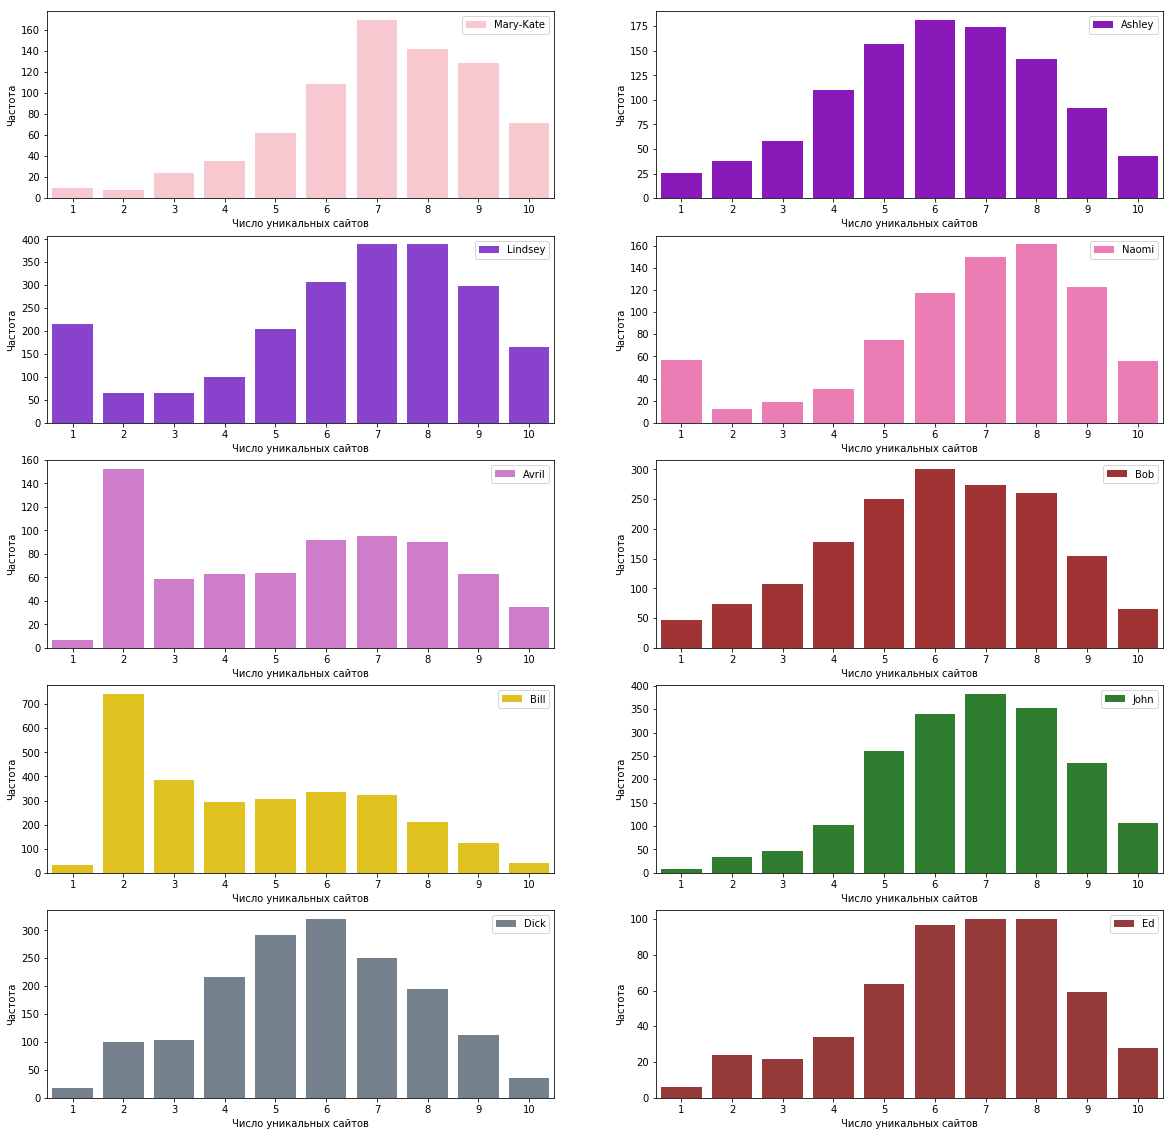

In [24]:
list_user = list(color_dic.keys())

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 20))
set_user = set(train_data_10users.target)

user = 1
for idx, ax in enumerate(axes):
    for i, a in enumerate(ax):
        sns.countplot(train_data_10users[train_data_10users.target == user]["#unique_sites"],
                      color=color_dic[list_user[user-1]], ax=axes[idx, i])
        axes[idx, i].set_xlabel('Число уникальных сайтов')
        axes[idx, i].set_ylabel('Частота')
        axes[idx, i].legend([list_user[user-1]])
        user = user + 1

**4. Постройте гистограмму распределения часа начала сессии (start_hour). Сделайте гистограмму цвета darkgreen, подпишите оси по-русски.**

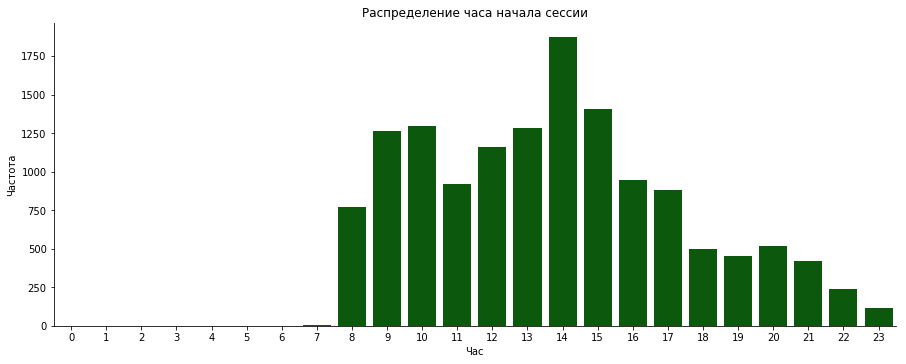

In [25]:
ax =sns.catplot(x="start_hour", kind="count", color='darkgreen', data=train_data_10users,
                order = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
                height=5, aspect=2.5)
plt.title("Распределение часа начала сессии", fontsize=12)
plt.xlabel("Час", fontsize=10)
plt.ylabel("Частота", fontsize=10)
plt.show()

**5. Постройте гистограммы распределения часа начала сессии (start_hour) для каждого из 10 пользователей по отдельности. Используйте subplots, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (color_dic). Подпишите оси по-русски в каждой из 10 гистограмм.**

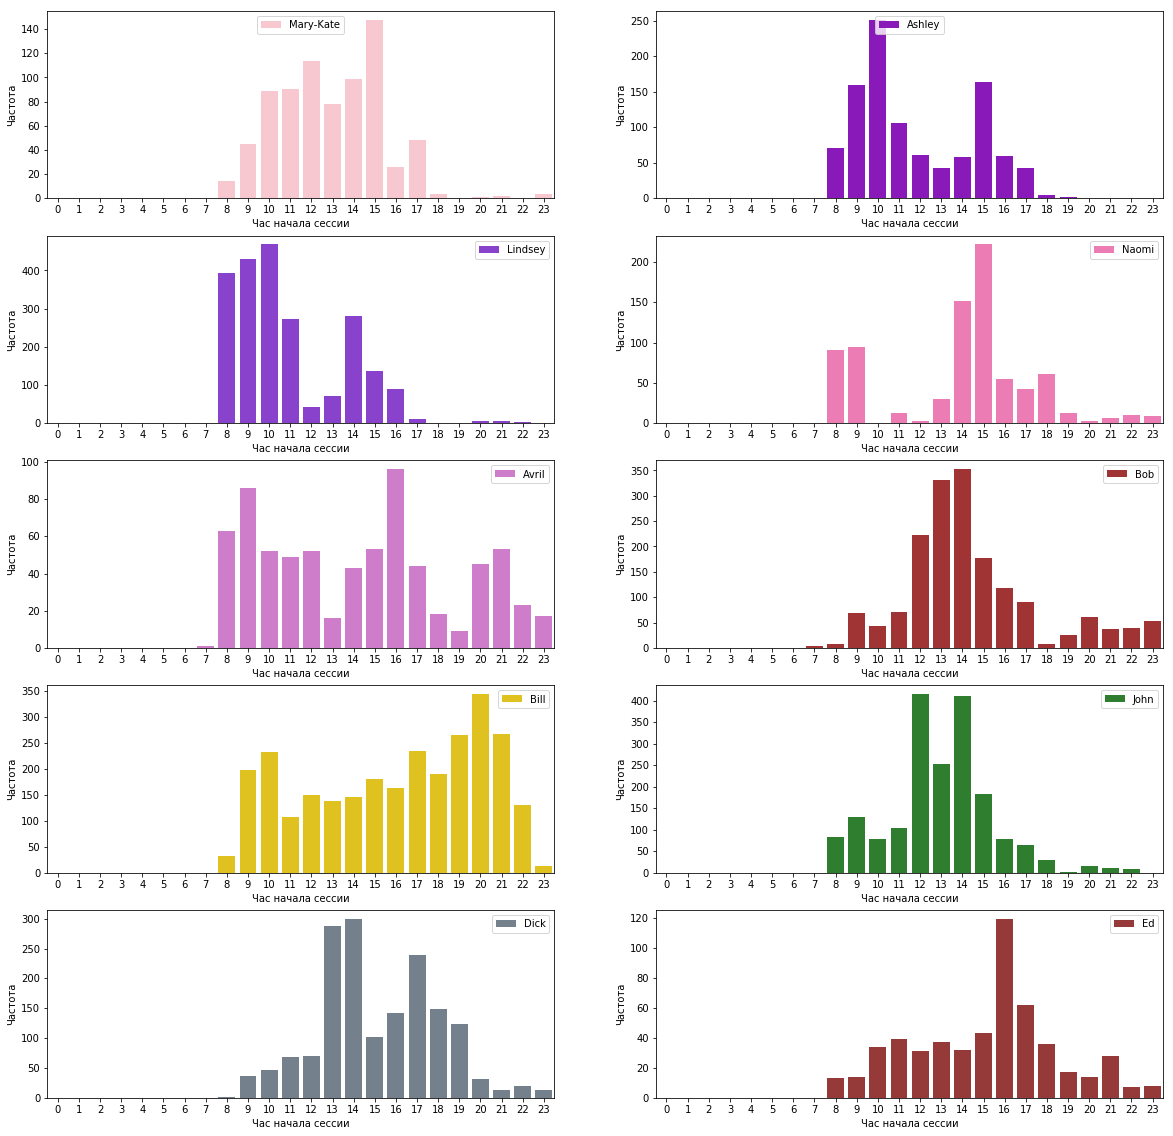

In [26]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 20))
set_user = set(train_data_10users.target)

user = 1
for idx, ax in enumerate(axes):
    for i, a in enumerate(ax):
        sns.countplot(train_data_10users[train_data_10users.target == user]["start_hour"],
                      color=color_dic[list_user[user-1]], 
                      order = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
                      ax=axes[idx, i])
        axes[idx, i].set_xlabel('Час начала сессии')
        axes[idx, i].set_ylabel('Частота')
        axes[idx, i].legend([list_user[user-1]])
        user = user + 1

**6. Постройте гистограмму распределения дня недели, в который началась сессия (day_of_week). Сделайте гистограмму цвета sienna, подпишите оси по-русски.**

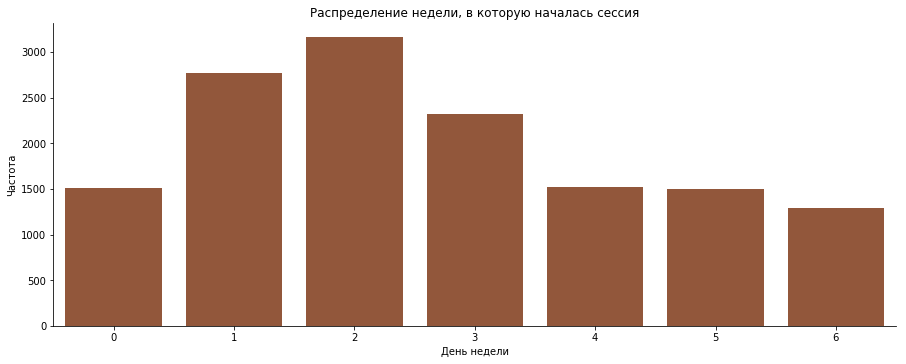

In [27]:
ax =sns.catplot(x="day_of_week", kind="count", color='sienna', data=train_data_10users, height=5, aspect=2.5)
plt.title("Распределение недели, в которую началась сессия", fontsize=12)
plt.xlabel("День недели", fontsize=10)
plt.ylabel("Частота", fontsize=10)
plt.show()

**7. Постройте гистограммы распределения дня недели, в который началась сессия (day_of_week) для каждого из 10 пользователей по отдельности. Используйте subplots, чтоб разместить все 10 картинок на одной большой. Измените метки по оси X на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод set_xticklabels. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (color_dic). Подпишите по-русски название каждой из 10 гистограмм.**

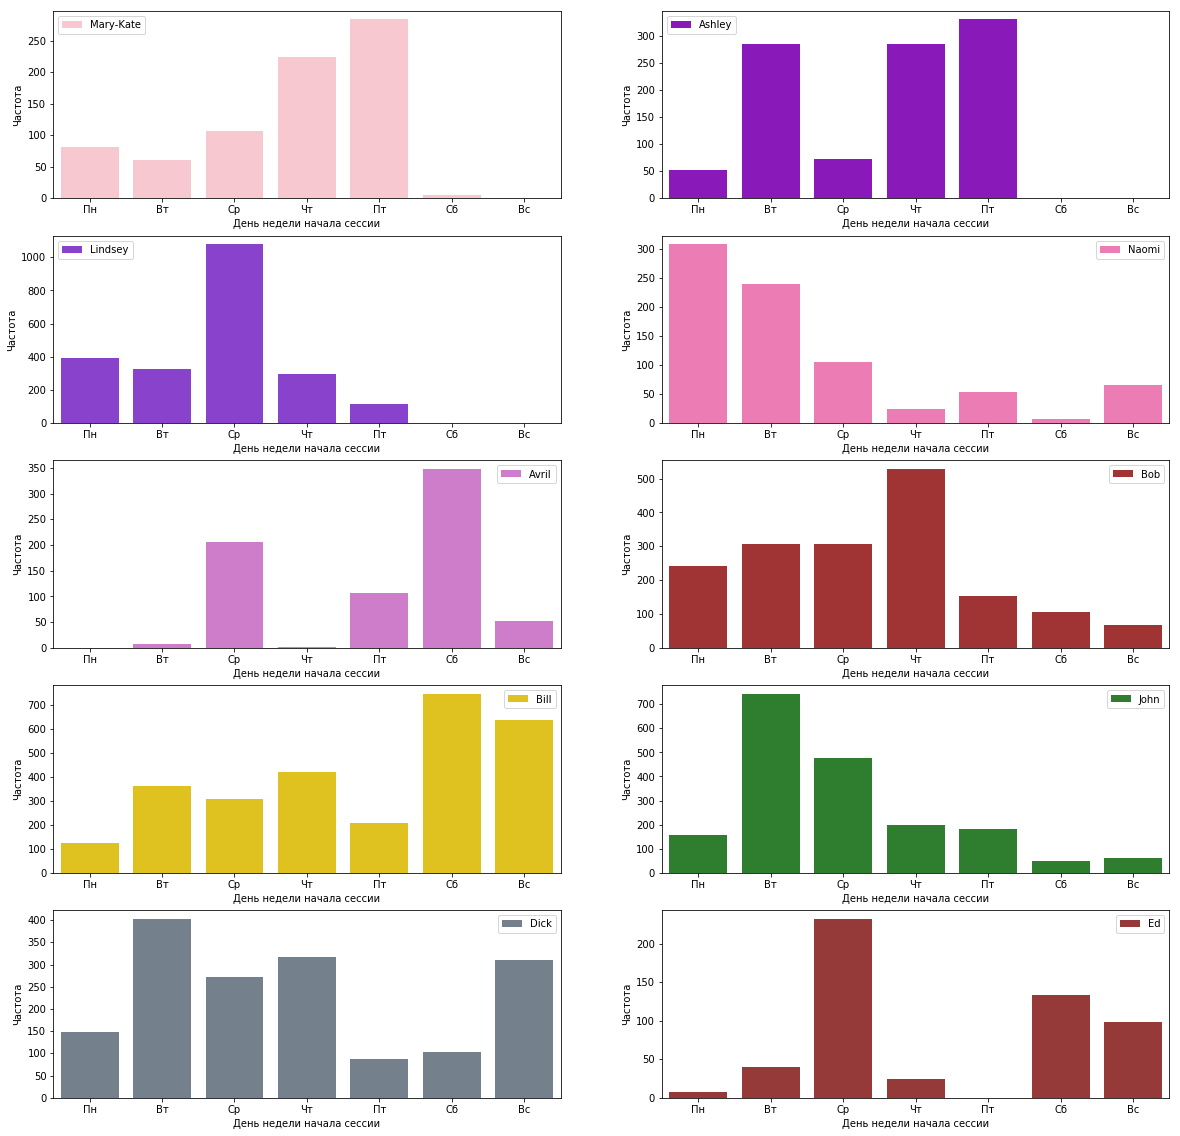

In [28]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 20))

user = 1
for idx, ax in enumerate(axes):
    for i, a in enumerate(ax):
        sns.countplot(train_data_10users[train_data_10users.target == user]["day_of_week"],
                      color=color_dic[list_user[user-1]], order = [0, 1, 2, 3, 4, 5, 6], ax=axes[idx, i])
        axes[idx, i].set_xlabel('День недели начала сессии')
        axes[idx, i].set_ylabel('Частота')
        axes[idx, i].legend([list_user[user-1]])
        axes[idx, i].set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб',  'Вс'])
        user = user+1

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

1. 'Mary-Kate' - частота количества уникальных сайтов совпадает с общей тенденцию, время начало на час позже общепринятого, а день начала сессии как правило приходился на конец рабочей неделе с максимумо в пятницу, хотя более принято начинать по средам 
2. 'Ashley'  - частота количества уникальных сайтов немного ниже от общей тенденцию, время начало на утренние время с максимумом в 10 утра, а день начала сессии как правило приходился на конец рабочей неделе с максимумо в пятницу как и у прошлого пользователя, хотя более принято начинать по средам
3. 'Lindsey' - частота количества уникальных сайтов совпадает с общей тенденцию. Так же было характерно и на один уникальный сайт больше. Время начало как правило приходилос с 8 до 10 часов. День начала сессии - ярко выражена среда по сравнению с другими днями. 
4. 'Naomi' - частота количества уникальных сайтов немного сдвинута в сторону увеличения по сравнению с общей тенденцию. Время начало как правило более часто так же было на час позже. День начала сессии - ярко выражена понедельник с падением до среды. Остальные дни на минамальном уровне. 
5. 'Avril' - частота количества уникальных сайтов характерно 2. В общей тенденции это количество так же незначительно выделяется. немного сдвинута в сторону увеличения по сравнению с общей тенденцию. Так же было характерно и на один больше. Распределение время начало как правило совпадает с общей картиной, но в отличие имеет более ярко выраженый хвост в вечернее время. День начала - среда или суббота. 
6. 'Bob' - характерно немного сдвинутое в меньшую сторону число уникальных сайтов. Частота времени начала совпадает с максимального времени начала общим в 14 часов. День недели более характерен четверг. Остальные дни в начале приблизительно равны.
7. 'Bill' - наиболее характерно 2 уникаальных сайта, а потом идет понижение. Время начало наиболее выделяется с 9 до 10 утра и с 19 до 21 вечера. Наиболее характерные дни начала - выходные. 
8. 'John' - частота большого количества уникальных сайтов совпадает с общей тенденцией и составляет максимум на 7. Наиболее ярко выражены часы - 12 и как при общей тенденции - 14. Дни недели начала - вторник и среда с максимумом в среду.
9. 'Dick'- число уникальных сайтов на один меньше, чем в общей тенденции. Час начала максимальны в 13 и 14, с максимумом в 14 как и при общей. Дни недели - вторник, среда, четверг и воскресенья. Остальнын в два раза меньше и практически равнозначны.
10. 'Ed' - гистограмма числа уникальных сайтов совпадает с общей гистограммой. Время начало сдвинуто в большую сторону на 16. Максимум составляет в среду как при общей, так в субботу и воскресенье.Остальные дни не ярко выражены.

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей.**

In [29]:
with open("capstone_websites_data/site_freq_10users.pkl", 'rb') as fid:
    site_freq_10 = pickle.load(fid)

**Определите топ-10 самых посещаемых сайтов (top10_sites) и соответствующие кол-ва посещений (top10_freqs).**

In [30]:
ten_best = list(site_freq_10.keys())[:10]
for site in list(ten_best):
    print(site)

s.youtube.com
www.google.fr
www.google.com
mail.google.com
www.facebook.com
apis.google.com
r3---sn-gxo5uxg-jqbe.googlevideo.com
r1---sn-gxo5uxg-jqbe.googlevideo.com
plus.google.com
accounts.google.com


In [31]:
feature_names_two = ['site' + str(i) for i in range(1,11)]
train_data_10users_array = train_data_10users[feature_names_two].values
unique, counts = np.unique(train_data_10users_array, return_counts=True)
ten_max_site = {}
for u, c in dict(zip(unique, counts)).items():
    if u == 0:
        continue
    elif u > 10:
        break
    else:
        ten_max_site[ten_best[u-1]] = c

In [41]:
top10_freqs = list(ten_max_site.values())
top10_sites = list(ten_max_site.keys())

**9. Нарисуйте seaborn barplot, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (xticks).**

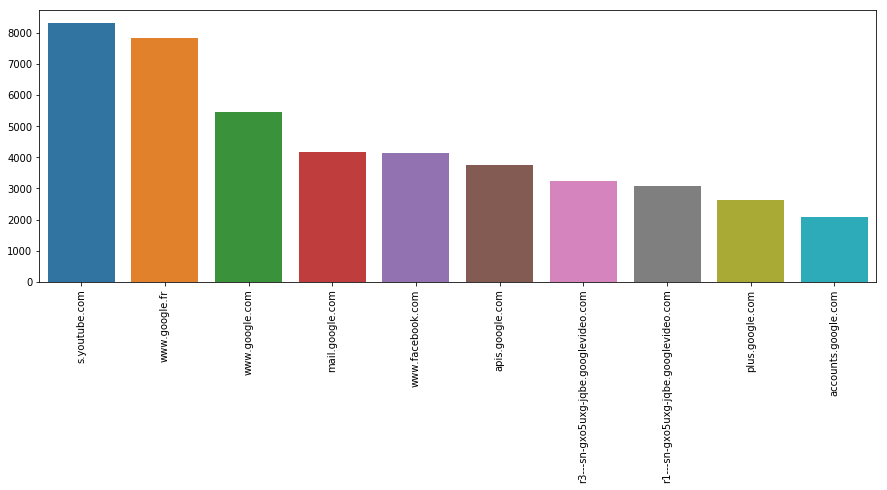

In [49]:
fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.barplot(x=top10_sites, y=top10_freqs)
plt.xticks(rotation = 90)
plt.show()

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки.

На следующей неделе мы будем использовать "мешок" сайтов для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):

* год, месяц и день начала сессии
* час начала сессии (с учетом года, месяца и дня)
* время суток
* среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
* индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
* частота посещения Facebook
* ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами session_length=10 и window_size=10. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [52]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,192,574,133,3,133,133,3,133,203,133,10,0,0,1,20,1,0,1,0,33,5,8,4,1
1,415,193,674,254,133,31,393,3305,217,55,1,0,163,105,0,1,3,3,8,284,10,8,4,1
2,55,3,55,55,5,293,415,333,897,55,0,14,1,242,0,0,1,0,0,258,7,8,4,1
3,473,3306,473,55,55,55,55,937,199,123,2,1,0,1,25,1,0,0,0,30,6,8,4,1
4,342,55,5,3307,258,211,3308,2086,675,2086,1,0,1,1,1,0,1,1,0,6,9,8,4,1


In [372]:
def feature_engineering(train_data):
    df_new = train_data.copy()
    #введем бинарный показатель 0 - будни, 1 - выходные
    df_new['weekday'] = df_new['day_of_week'].apply(lambda x: 1 if x > 4 else 0)
    #были ли в эту сесссеию топ 10 сайтов
    site_col_list = ['site' + str(i) for i in range(1,11)]
    df_new['popular'] = df_new[df_new[site_col_list]<11].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)
    #количество популярных сайтов
    df_new['count_popular'] = 10 - df_new[site_col_list][df_new[site_col_list]<11].isna().sum(axis=1)
    #время проведенное на популярных сайта
    time_diff_num = ['time_diff' + str(i) for i in range(1,10)]
    print(df_new[site_col_list][df_new[site_col_list]<11].values.shape)
    
    row = 0
    rows = []
    cols = []
    data = []

    
    tmp_arr = np.nan_to_num(np.array(df_new[site_col_list][df_new[site_col_list]<11]))
    for arr in tmp_arr:
        for key, value in enumerate(arr):
            if value != 0:
                rows.append(row)
                cols.append(key)
                data.append(value)
        row = row + 1
    
    
    row_count = -1
    sum_time = 0
    sum_time_sess = [0]*df_new.shape[0]
    for r, c in zip(rows, cols):
        #print(sum_time_sess[row_count])
        if(c==9):
            continue        
        elif r==row_count:
            #sum_time = sum_time + df_new.loc[r][c+10]
            sum_time_sess[row_count] = sum_time_sess[row_count] + df_new.loc[r][c+10]
            #print("1 ", "r ", r, " c ", c, " val ", df_new.loc[r][c], " time ", df_new.loc[r][c+10])
        else:
            sum_time_sess[r] = df_new.loc[r][c+10]
            #print("3 ", "r ", r, " c ", c, " val ", df_new.loc[r][c], " time ", df_new.loc[r][c+10])
            row_count = r
    df_new['time_popular'] = sum_time_sess
    return(df_new)

In [462]:
new_futures = feature_engineering(train_data_10users)

(14061, 10)


**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

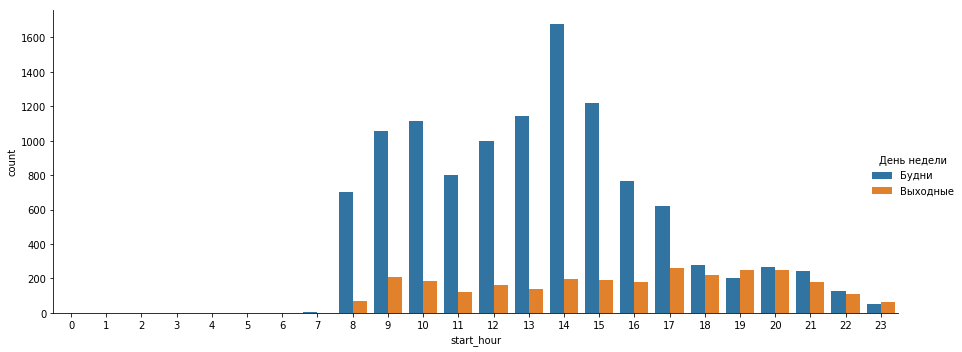

In [382]:
ax =sns.catplot(x="start_hour", kind="count", hue="weekday", data=new_futures,
                order = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
                height=5, aspect=2.5)

# title
new_title = 'День недели'
ax._legend.set_title(new_title)
# replace labels
new_labels = ['Будни', 'Выходные']
for t, l in zip(ax._legend.texts, new_labels): t.set_text(l)

#sns.plt.show()

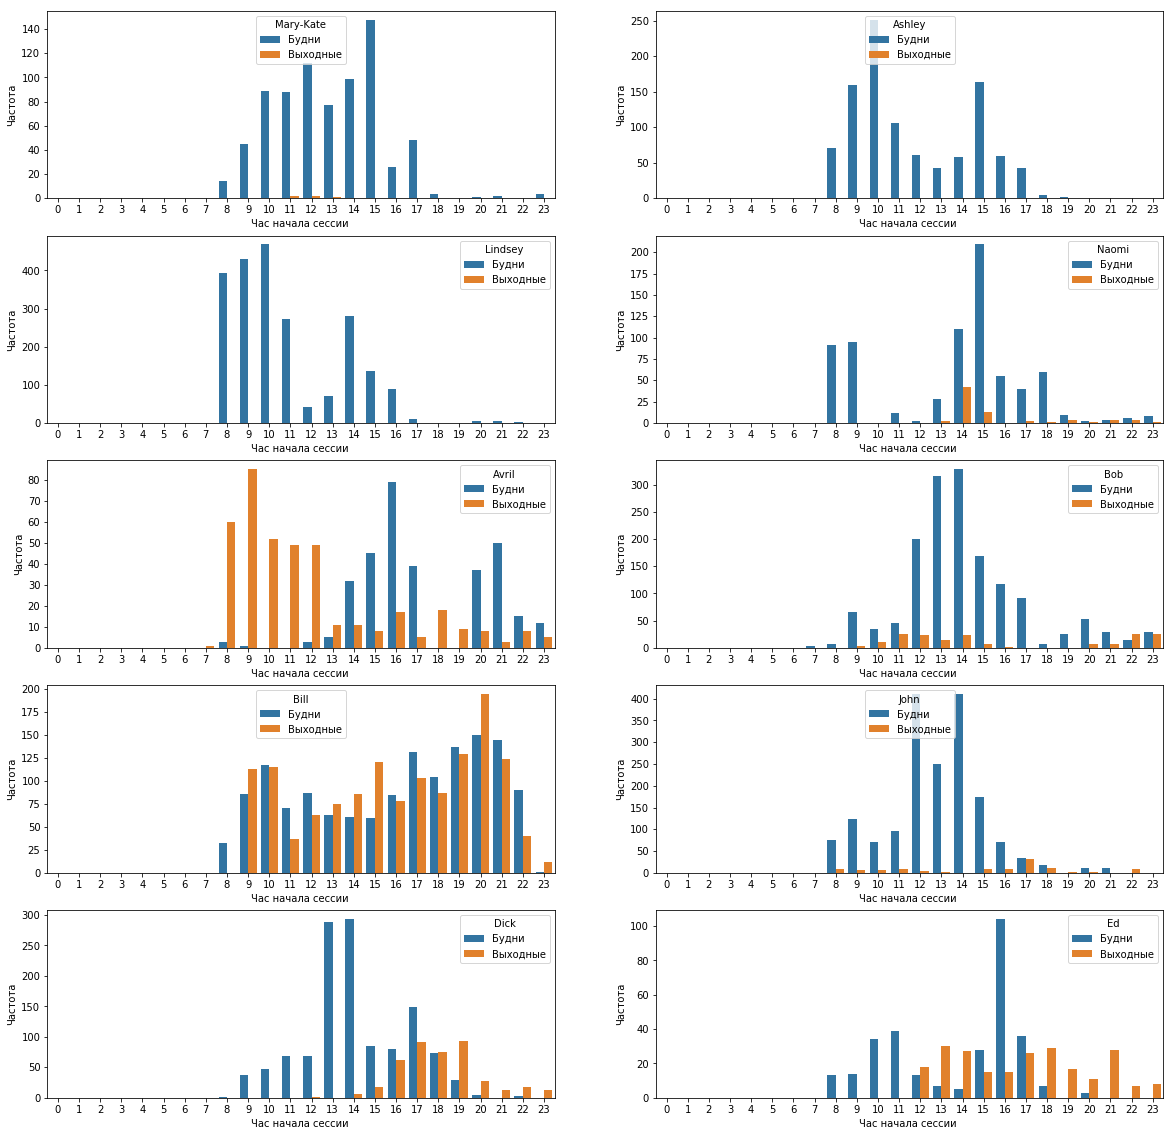

In [458]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 20))

user = 1
for idx, ax in enumerate(axes):
    for i, a in enumerate(ax):
        sns.countplot(new_futures[(new_futures.target == user)]["start_hour"], hue = 'weekday',
                      data = new_futures,
                      order = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
                      ax=axes[idx, i])
        axes[idx, i].set_xlabel('Час начала сессии ')
        axes[idx, i].set_ylabel('Частота')
        axes[idx, i].legend(['Будни', 'Выходные'], title = list_user[user-1])
        user = user + 1



Расссмотрение распределения по времени в зависимости от того, выходные это дни или будние дни принес дополнительные характеристики по пользователям. Трое пользователей или вообще не выходят в интернет, или очень мало используют компьютер в выходные дни, у четырех серфинг в интернете в выходные значительно снижается, у троих оставшихся практически без изменений, только для двоих характерно смещение активности.

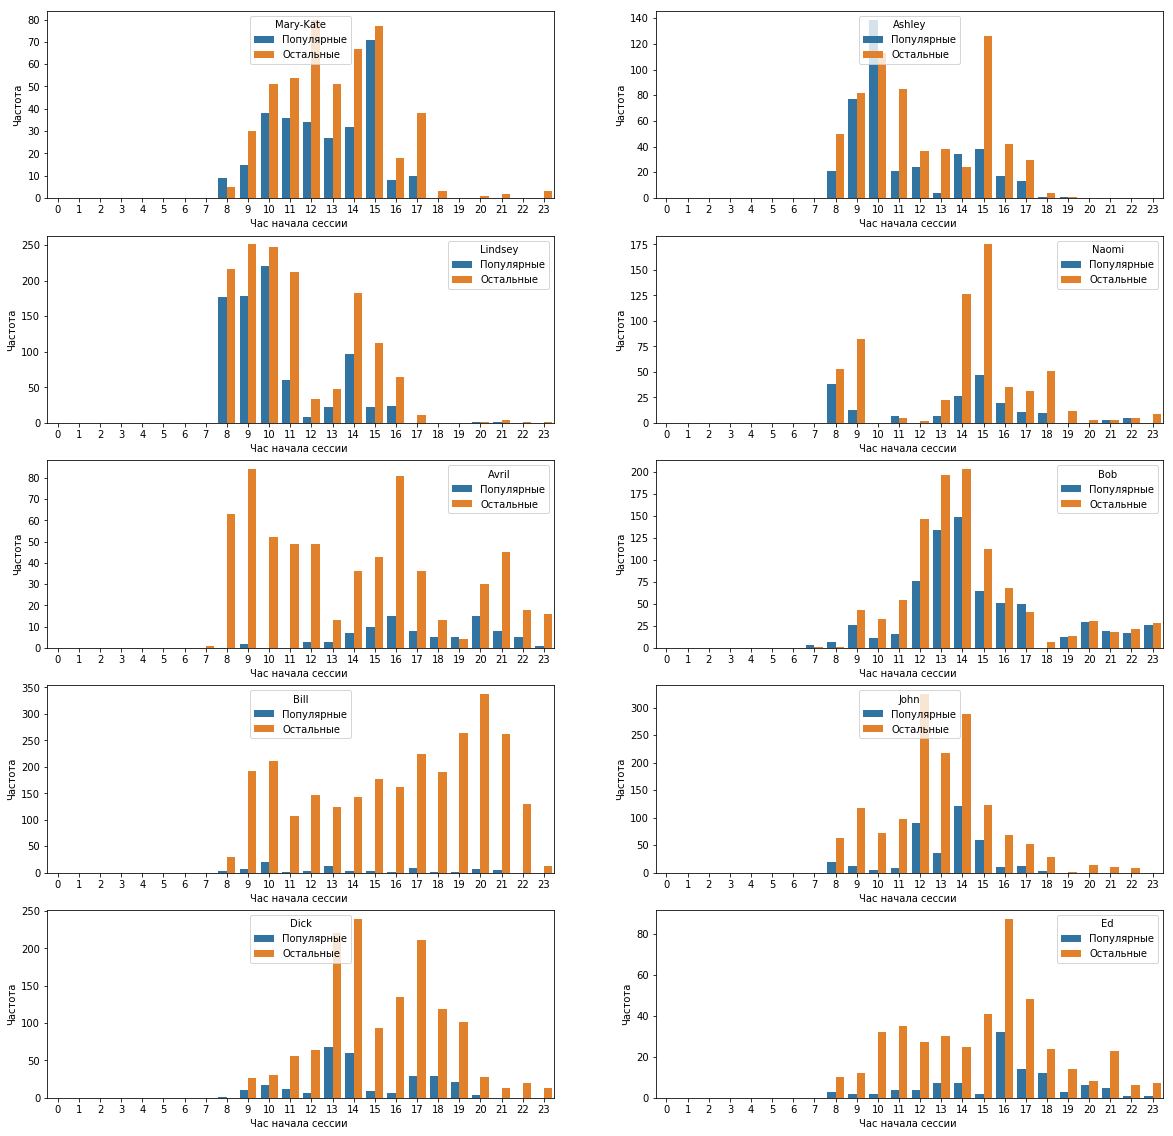

In [459]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 20))

user = 1
for idx, ax in enumerate(axes):
    for i, a in enumerate(ax):
        sns.countplot(new_futures[(new_futures.target == user)]["start_hour"], hue = 'popular',
                      data = new_futures,
                      order = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
                      ax=axes[idx, i])
        axes[idx, i].set_xlabel('Час начала сессии ')
        axes[idx, i].set_ylabel('Частота')
        axes[idx, i].legend(['Популярные', 'Остальные'], title = list_user[user-1])
        user = user + 1

Для четырех пользователей частота посещения по времени популярных сайтов совпадает с остальными, правда у некоторых наблюдается смещение оценки на утренние часы. У трех пользователей омечается рост в обеденное время с 13 до 15 часов.

In [464]:
new_futures.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,...,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target,weekday,popular,count_popular,time_popular
0,192,574,133,3,133,133,3,133,203,133,10,0,...,0,1,0,33,5,8,4,1,0,1,2,1
1,415,193,674,254,133,31,393,3305,217,55,1,0,...,3,3,8,284,10,8,4,1,0,0,0,0
2,55,3,55,55,5,293,415,333,897,55,0,14,...,1,0,0,258,7,8,4,1,0,1,2,14
3,473,3306,473,55,55,55,55,937,199,123,2,1,...,0,0,0,30,6,8,4,1,0,0,0,0
4,342,55,5,3307,258,211,3308,2086,675,2086,1,0,...,1,1,0,6,9,8,4,1,0,1,1,1


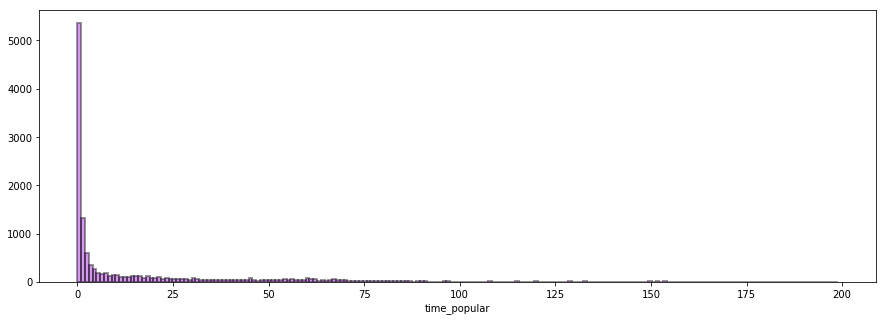

In [476]:
x = new_futures[new_futures.time_popular < 200].time_popular
fig, ax = plt.subplots(figsize=(15, 5))
sns.distplot(x, bins=200, kde=False, color='darkviolet', hist_kws=dict(edgecolor="k", linewidth=2))

In [485]:
x = new_futures[(new_futures.time_popular < 200) & (new_futures.target == 1)].time_popular

In [ ]:
plt.title("Распределение длины сессии")
plt.xlabel("Длина сессии в секундах")
plt.ylabel("Частота")

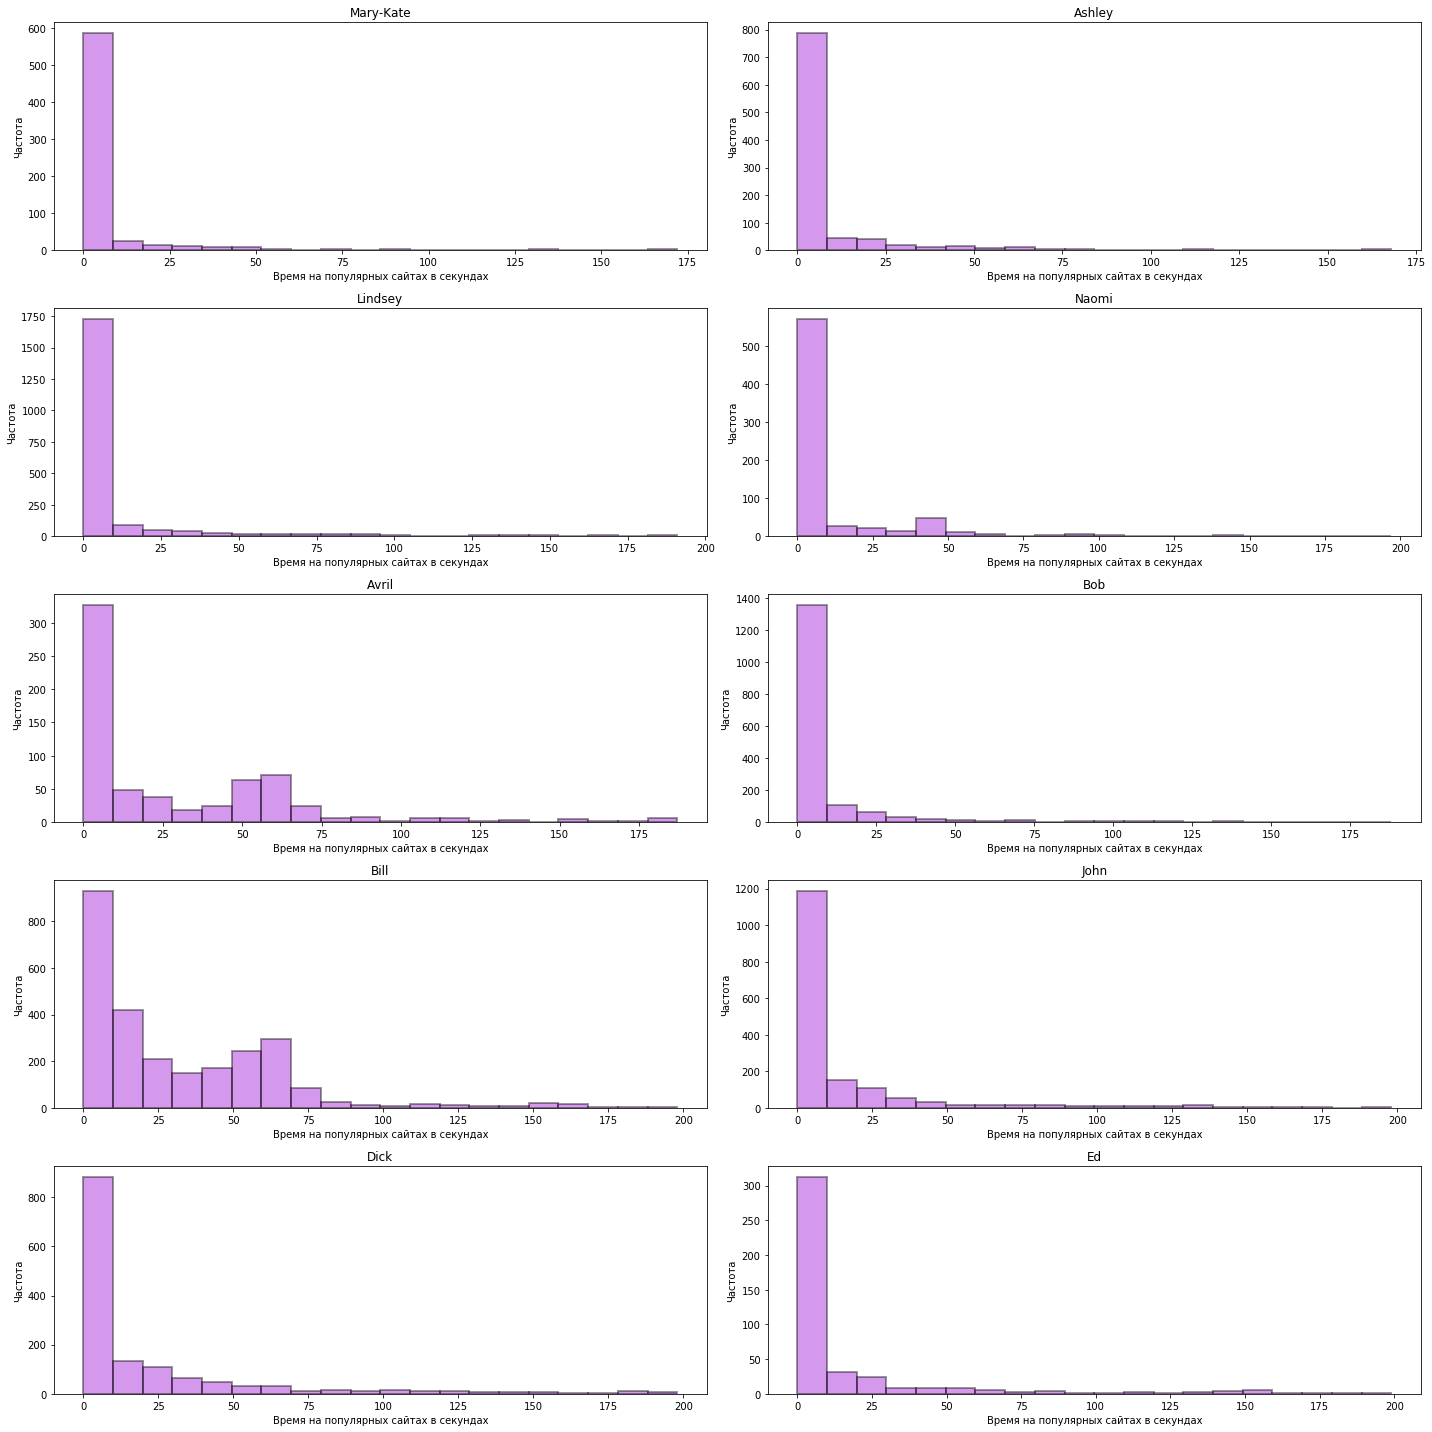

In [497]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 20))

user = 1
for idx, ax in enumerate(axes):
    for i, a in enumerate(ax):
        x = new_futures[(new_futures.time_popular < 200) & (new_futures.target == user)].time_popular
        sns.distplot(x, bins=20, kde=False, color='darkviolet', hist_kws=dict(edgecolor="k", linewidth=2), ax=axes[idx, i])
        axes[idx, i].set_xlabel('Время на популярных сайтах в секундах')
        axes[idx, i].set_ylabel('Частота')
        axes[idx, i].set_title(list_user[user-1])
        plt.tight_layout()
        user = user + 1

Благодоря анализу видно, что на топ 10 сайтов люди как правило заходят не надолго. Можно еще посчитать отдельно для популярной соцсети. Но даже сейчас среди пользователей выделяются три фаната.

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (session_timespan, #unique_sites, start_hour, day_of_week), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров session_length и window_size.**

In [499]:
selected_features_10users = feature_engineering(train_data_10users)
selected_features_150users = feature_engineering(train_data_150users)

(14061, 10)
(137019, 10)


In [500]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)